# Going Deeper(CV) - 2. 없다면 어떻게 될까? (ResNet Ablation Study)

Deep Residual Learning for Image Recognition에 나오는 ResNet을 구현해 보자.

---

### 루브릭 평가 기준

1. 

---

### 목차

0) 필요 모듈 import


1) 데이터 로드


2) ResNet


3) Ablation Study
  - ResNet-34 Vs Plain-34
  - ResNet-50 Vs Plain-50


4) 결과 비교


5) 회고



#### 학습 진행중입니다ㅜㅜ 최대한 빠르게 수정할 예정입니다

## 0. 필요 모듈 import

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import urllib3

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## 1. 데이터 로드

In [3]:
urllib3.disable_warnings()

(ds_train, ds_test), ds_info = tfds.load(
    'cats_vs_dogs',
    split=['train[:80%]', 'train[80%:]'],
    as_supervised=True,
    shuffle_files=True,
    with_info=True,
)

train, test의 구분이 없는 데이터이므로 전체 데이터에서 80%를 train set, 20%를 validation set으로 사용한다.


In [4]:
print(tf.data.experimental.cardinality(ds_train))
print(tf.data.experimental.cardinality(ds_test))

tf.Tensor(18610, shape=(), dtype=int64)
tf.Tensor(4652, shape=(), dtype=int64)


In [5]:
print(ds_info.features)

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=tf.uint8),
    'image/filename': Text(shape=(), dtype=tf.string),
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
})


이미지 크기가 제각각이라 크기가 None으로 표시된다.   
이를 학습에 이용하기 위해서는 이미지의 크기를 맞춰주는 과정을 거쳐준다.

In [6]:
print(ds_info.features["label"].num_classes)

print(ds_info.features["label"].names)

2
['cat', 'dog']


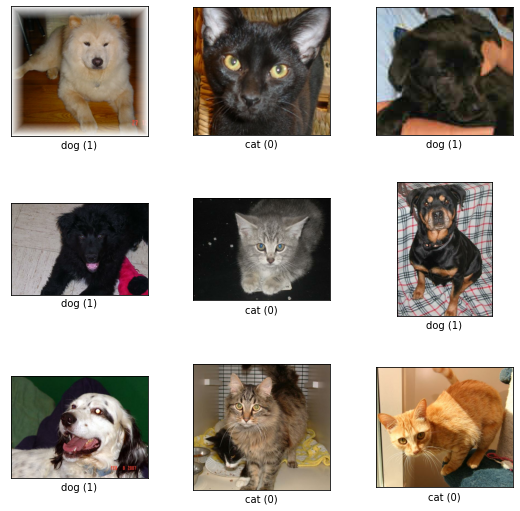

In [7]:
fig = tfds.show_examples(ds_train, ds_info)

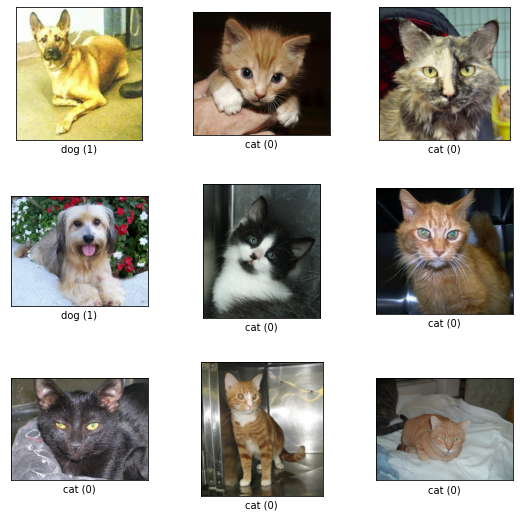

In [8]:
fig = tfds.show_examples(ds_test, ds_info)

In [9]:
def normalize_and_resize_img(image, label):
    image = tf.image.resize(image, [224, 224])
    return tf.cast(image, tf.float32) / 255., label

In [10]:
def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=1
    )
    ds = ds.batch(batch_size)
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds

ResNet 만들기  
34레이어 모델과 50레이어 모델은 블럭의 구성이 다르므로 이를 구분하여 만들어줄 필요가 있음

In [11]:
def build_resnet_block_34(x, channel, kernel_size=3, stride=1, conv_shortcut=True, is_plain=False):
    # skip-connection
    if conv_shortcut:
        shortcut = layers.Conv2D(channel, 1, strides=stride, padding='same')(x)
        shortcut = layers.BatchNormalization()(shortcut)

    else:
        shortcut = x     
    
    # CNN layer
    if conv_shortcut:
        x1 = layers.Conv2D(filters=channel, kernel_size=3, strides=2, padding='same')(x)
    else:
        x1 = layers.Conv2D(channel, 3, strides=1, padding='same')(x)

    x1 = layers.BatchNormalization()(x1)
    x1 = layers.ReLU()(x1)

    x1 = layers.Conv2D(channel, 3, strides=1, padding='same')(x1)
    x1 = layers.BatchNormalization()(x1)
    
    if is_plain:
        x1 = layers.ReLU()(x1)
        return x1
    else:
        x = layers.Add()([x1, shortcut])
        x = layers.ReLU()(x)
        
        return x

In [12]:
def build_resnet_block_50(x, channel, kernel_size=3, stride=1, conv_shortcut=True, is_plain=False):
    # skip-connection
    if conv_shortcut:
        shortcut = layers.Conv2D(channel * 4, 1, strides=stride, padding='same')(x)
        shortcut = layers.BatchNormalization()(shortcut)

    else:
        shortcut = x
    
    # CNN layer
    if conv_shortcut:
        x1 = layers.Conv2D(channel, 1, strides=stride, padding='same')(x)
    else:
        x1 = layers.Conv2D(channel, 1, strides=1, padding='same')(x)
        
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.ReLU()(x1)

    x1 = layers.Conv2D(channel, 3, strides=1, padding='same')(x1)
    x1 = layers.BatchNormalization()(x1)
    x1 = layers.ReLU()(x1)
    
    x1 = layers.Conv2D(channel * 4, 1, strides=1, padding='same')(x1)
    x1 = layers.BatchNormalization()(x1)
    
    if is_plain:
        x1 = layers.ReLU()(x1)
        return x1
    else:
        x = layers.Add()([x1, shortcut])
        x = layers.ReLU()(x)
        return x

In [13]:
def build_resnet_blocks(input_layer, 
                        num_cnn=3, 
                        channel=64, 
                        strides=1,
                        block_num=0, 
                        is_plain=False, 
                        is_50=False):
    # input layer
    x = input_layer
    if is_50:
        for i in range(num_cnn):
            if block_num == 2 and i == 0:
                x = build_resnet_block_50(x, channel, is_plain=is_plain)
            elif block_num != 2 and i == 0:
                x = build_resnet_block_50(x, channel, stride=2, is_plain=is_plain)
            else:
                x = build_resnet_block_50(x, channel,  conv_shortcut=False, is_plain=is_plain)
    else:
        for i in range(num_cnn):
            if block_num != 2 and i == 0:
                x = build_resnet_block_34(x, channel, stride=2, is_plain=is_plain)
            else:
                x = build_resnet_block_34(x, channel, conv_shortcut=False, is_plain=is_plain)
        
    return x

In [14]:
def build_resnet(input_shape=(224, 224, 3), 
                 num_cnn_list=[3, 4, 6, 3], 
                 channel_list=[64, 128, 256, 512], 
                 num_classes=10, 
                 is_plain=False, 
                 is_50=False):
    
    assert len(num_cnn_list) == len(channel_list) # 모델을 만들기 전에 config list들이 같은 길이인지 확인
    
    input_layer = layers.Input(shape=input_shape)
    output = input_layer
    
    # conv1층
    output = layers.Conv2D(64, kernel_size=(7, 7), strides=2, padding='same', name='conv1')(output)
    output = layers.BatchNormalization()(output)
    output = layers.ReLU()(output)
    # conv2_x pooling
    output = layers.MaxPool2D(pool_size=(3, 3), strides=2, padding='same', name='conv2_maxpool2d')(output)
    
    # config list들의 길이만큼 반복해서 블록을 생성
    for i, (num_cnn, channel) in enumerate(zip(num_cnn_list, channel_list)):
        output = build_resnet_blocks(output, 
                                    num_cnn=num_cnn, 
                                    channel=channel, 
                                    block_num=i+2,
                                    is_plain=is_plain,
                                    is_50=is_50)
        
    output = keras.layers.GlobalAveragePooling2D(name='average_pooling')(output)
    output = keras.layers.Flatten(name='flatten')(output)
    output = keras.layers.Dense(num_classes, activation='softmax', name='predictions')(output)
    
    model = keras.Model(inputs=input_layer, outputs=output)
    
    return model

ResNet-34 Vs Plain-34

In [15]:
BATCH_SIZE = 32
EPOCH = 15

In [16]:
ds_train = apply_normalize_on_dataset(ds_train, batch_size=BATCH_SIZE)
ds_test = apply_normalize_on_dataset(ds_test, batch_size=BATCH_SIZE)

In [17]:
resnet_34 = build_resnet(input_shape=(224, 224, 3))
resnet_34.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 112, 112, 64) 256         conv1[0][0]                      
__________________________________________________________________________________________________
re_lu (ReLU)                    (None, 112, 112, 64) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [18]:
resnet_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_34 = resnet_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/15


Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 30/581 [>.............................] - ETA: 1:30 - loss: 0.8907 - accuracy: 0.5938

 37/581 [>.............................] - ETA: 1:29 - loss: 0.8579 - accuracy: 0.5887

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


113/581 [====>.........................] - ETA: 1:16 - loss: 0.7454 - accuracy: 0.5938

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


320/581 [===============>..............] - ETA: 43s - loss: 0.6786 - accuracy: 0.6177

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


330/581 [================>.............] - ETA: 41s - loss: 0.6772 - accuracy: 0.6187

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


343/581 [================>.............] - ETA: 39s - loss: 0.6769 - accuracy: 0.6177

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


370/581 [==================>...........] - ETA: 35s - loss: 0.6730 - accuracy: 0.6211

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 34s - loss: 0.6716 - accuracy: 0.6221

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


577/581 [============================>.] - ETA: 0s - loss: 0.6513 - accuracy: 0.6389

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.6516 - accuracy: 0.6387

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 130s 196ms/step - loss: 0.6516 - accuracy: 0.6387 - val_loss: 0.7583 - val_accuracy: 0.5589
Epoch 2/15
 30/581 [>.............................] - ETA: 1:35 - loss: 0.6239 - accuracy: 0.6542

 39/581 [=>............................] - ETA: 1:33 - loss: 0.6234 - accuracy: 0.6611

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


113/581 [====>.........................] - ETA: 1:20 - loss: 0.6161 - accuracy: 0.6745

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


322/581 [===============>..............] - ETA: 45s - loss: 0.5963 - accuracy: 0.6832

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


332/581 [================>.............] - ETA: 43s - loss: 0.5967 - accuracy: 0.6828

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


345/581 [================>.............] - ETA: 41s - loss: 0.5953 - accuracy: 0.6836

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


372/581 [==================>...........] - ETA: 36s - loss: 0.5944 - accuracy: 0.6846

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 35s - loss: 0.5940 - accuracy: 0.6844

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.5836 - accuracy: 0.6952

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 115s 198ms/step - loss: 0.5836 - accuracy: 0.6952 - val_loss: 0.6021 - val_accuracy: 0.6912
Epoch 3/15
 29/581 [>.............................] - ETA: 1:37 - loss: 0.5433 - accuracy: 0.7252

 41/581 [=>............................] - ETA: 1:35 - loss: 0.5438 - accuracy: 0.7226

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


115/581 [====>.........................] - ETA: 1:22 - loss: 0.5493 - accuracy: 0.7136

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


321/581 [===============>..............] - ETA: 46s - loss: 0.5438 - accuracy: 0.7219

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


334/581 [================>.............] - ETA: 44s - loss: 0.5411 - accuracy: 0.7244

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


344/581 [================>.............] - ETA: 42s - loss: 0.5399 - accuracy: 0.7249

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


371/581 [==================>...........] - ETA: 37s - loss: 0.5377 - accuracy: 0.7262

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 36s - loss: 0.5378 - accuracy: 0.7265

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


580/581 [============================>.] - ETA: 0s - loss: 0.5322 - accuracy: 0.7319

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.5321 - accuracy: 0.7319

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 118s 204ms/step - loss: 0.5321 - accuracy: 0.7319 - val_loss: 0.5843 - val_accuracy: 0.6937
Epoch 4/15
 29/581 [>.............................] - ETA: 1:39 - loss: 0.5176 - accuracy: 0.7651

 43/581 [=>............................] - ETA: 1:37 - loss: 0.5181 - accuracy: 0.7580

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/581 [====>.........................] - ETA: 1:24 - loss: 0.5061 - accuracy: 0.7527

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


322/581 [===============>..............] - ETA: 47s - loss: 0.4940 - accuracy: 0.7620

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 44s - loss: 0.4946 - accuracy: 0.7615

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


346/581 [================>.............] - ETA: 42s - loss: 0.4930 - accuracy: 0.7624

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


373/581 [==================>...........] - ETA: 38s - loss: 0.4937 - accuracy: 0.7611

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


379/581 [==================>...........] - ETA: 36s - loss: 0.4942 - accuracy: 0.7609

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.4845 - accuracy: 0.7654

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 120s 207ms/step - loss: 0.4845 - accuracy: 0.7654 - val_loss: 0.6845 - val_accuracy: 0.6417
Epoch 5/15
  1/581 [..............................] - ETA: 1:44 - loss: 0.4570 - accuracy: 0.8125

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 32/581 [>.............................] - ETA: 1:40 - loss: 0.4410 - accuracy: 0.8018

 41/581 [=>............................] - ETA: 1:38 - loss: 0.4410 - accuracy: 0.8003

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


116/581 [====>.........................] - ETA: 1:25 - loss: 0.4453 - accuracy: 0.7961

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


324/581 [===============>..............] - ETA: 47s - loss: 0.4414 - accuracy: 0.7976

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


334/581 [================>.............] - ETA: 45s - loss: 0.4396 - accuracy: 0.7988

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


349/581 [=================>............] - ETA: 42s - loss: 0.4382 - accuracy: 0.8001

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 37s - loss: 0.4396 - accuracy: 0.7992

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 36s - loss: 0.4377 - accuracy: 0.8001

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.4248 - accuracy: 0.8058

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 121s 208ms/step - loss: 0.4248 - accuracy: 0.8058 - val_loss: 0.5128 - val_accuracy: 0.7439
Epoch 6/15
  3/581 [..............................] - ETA: 1:46 - loss: 0.3605 - accuracy: 0.8229

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 34/581 [>.............................] - ETA: 1:40 - loss: 0.3675 - accuracy: 0.8392

 43/581 [=>............................] - ETA: 1:38 - loss: 0.3820 - accuracy: 0.8314

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


118/581 [=====>........................] - ETA: 1:24 - loss: 0.3811 - accuracy: 0.8300

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


323/581 [===============>..............] - ETA: 47s - loss: 0.3830 - accuracy: 0.8280

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


336/581 [================>.............] - ETA: 45s - loss: 0.3814 - accuracy: 0.8283

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


348/581 [================>.............] - ETA: 42s - loss: 0.3805 - accuracy: 0.8289

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


375/581 [==================>...........] - ETA: 37s - loss: 0.3788 - accuracy: 0.8304

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 36s - loss: 0.3790 - accuracy: 0.8303

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.3717 - accuracy: 0.8342

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 121s 208ms/step - loss: 0.3717 - accuracy: 0.8342 - val_loss: 0.5459 - val_accuracy: 0.7429
Epoch 7/15
  1/581 [..............................] - ETA: 1:45 - loss: 0.2514 - accuracy: 0.9062

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 35/581 [>.............................] - ETA: 1:40 - loss: 0.3235 - accuracy: 0.8643

 44/581 [=>............................] - ETA: 1:38 - loss: 0.3279 - accuracy: 0.8601

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


118/581 [=====>........................] - ETA: 1:24 - loss: 0.3245 - accuracy: 0.8610

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


327/581 [===============>..............] - ETA: 46s - loss: 0.3216 - accuracy: 0.8613

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


337/581 [================>.............] - ETA: 44s - loss: 0.3223 - accuracy: 0.8605

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


350/581 [=================>............] - ETA: 42s - loss: 0.3217 - accuracy: 0.8617

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


377/581 [==================>...........] - ETA: 37s - loss: 0.3207 - accuracy: 0.8616

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 36s - loss: 0.3206 - accuracy: 0.8618

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.3115 - accuracy: 0.8643

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 121s 208ms/step - loss: 0.3115 - accuracy: 0.8643 - val_loss: 0.4197 - val_accuracy: 0.8067
Epoch 8/15
  3/581 [..............................] - ETA: 1:45 - loss: 0.3263 - accuracy: 0.8438

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 36/581 [>.............................] - ETA: 1:39 - loss: 0.2714 - accuracy: 0.8776

 47/581 [=>............................] - ETA: 1:38 - loss: 0.2710 - accuracy: 0.8790

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


119/581 [=====>........................] - ETA: 1:25 - loss: 0.2707 - accuracy: 0.8831

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


327/581 [===============>..............] - ETA: 46s - loss: 0.2609 - accuracy: 0.8899

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


340/581 [================>.............] - ETA: 44s - loss: 0.2612 - accuracy: 0.8899

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


349/581 [=================>............] - ETA: 42s - loss: 0.2598 - accuracy: 0.8903

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


376/581 [==================>...........] - ETA: 37s - loss: 0.2582 - accuracy: 0.8905

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 36s - loss: 0.2578 - accuracy: 0.8906

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.2467 - accuracy: 0.8962

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 121s 209ms/step - loss: 0.2467 - accuracy: 0.8962 - val_loss: 0.4670 - val_accuracy: 0.8106
Epoch 9/15
  6/581 [..............................] - ETA: 1:45 - loss: 0.1931 - accuracy: 0.9323

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 37/581 [>.............................] - ETA: 1:40 - loss: 0.1981 - accuracy: 0.9206

 47/581 [=>............................] - ETA: 1:38 - loss: 0.2064 - accuracy: 0.9189

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


120/581 [=====>........................] - ETA: 1:24 - loss: 0.1955 - accuracy: 0.9221

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


326/581 [===============>..............] - ETA: 47s - loss: 0.1938 - accuracy: 0.9233

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


340/581 [================>.............] - ETA: 44s - loss: 0.1949 - accuracy: 0.9230

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


351/581 [=================>............] - ETA: 42s - loss: 0.1936 - accuracy: 0.9240

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


378/581 [==================>...........] - ETA: 37s - loss: 0.1926 - accuracy: 0.9241

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


384/581 [==================>...........] - ETA: 36s - loss: 0.1914 - accuracy: 0.9243

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.1817 - accuracy: 0.9283

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 121s 209ms/step - loss: 0.1817 - accuracy: 0.9283 - val_loss: 1.0560 - val_accuracy: 0.6922
Epoch 10/15
  7/581 [..............................] - ETA: 1:44 - loss: 0.1061 - accuracy: 0.9598

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 37/581 [>.............................] - ETA: 1:39 - loss: 0.1742 - accuracy: 0.9375

 47/581 [=>............................] - ETA: 1:37 - loss: 0.1828 - accuracy: 0.9309

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


122/581 [=====>........................] - ETA: 1:24 - loss: 0.1497 - accuracy: 0.9416

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


327/581 [===============>..............] - ETA: 46s - loss: 0.1318 - accuracy: 0.9480

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


340/581 [================>.............] - ETA: 44s - loss: 0.1315 - accuracy: 0.9483

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


353/581 [=================>............] - ETA: 42s - loss: 0.1308 - accuracy: 0.9483

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


380/581 [==================>...........] - ETA: 37s - loss: 0.1313 - accuracy: 0.9482

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


386/581 [==================>...........] - ETA: 35s - loss: 0.1313 - accuracy: 0.9482

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.1267 - accuracy: 0.9506

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 121s 209ms/step - loss: 0.1267 - accuracy: 0.9506 - val_loss: 0.5810 - val_accuracy: 0.8098
Epoch 11/15
  5/581 [..............................] - ETA: 1:45 - loss: 0.1136 - accuracy: 0.9563

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 37/581 [>.............................] - ETA: 1:40 - loss: 0.1087 - accuracy: 0.9535

 48/581 [=>............................] - ETA: 1:38 - loss: 0.1066 - accuracy: 0.9570

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


124/581 [=====>........................] - ETA: 1:24 - loss: 0.1115 - accuracy: 0.9544

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


329/581 [===============>..............] - ETA: 46s - loss: 0.1122 - accuracy: 0.9560

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


341/581 [================>.............] - ETA: 44s - loss: 0.1113 - accuracy: 0.9558

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


354/581 [=================>............] - ETA: 41s - loss: 0.1115 - accuracy: 0.9558

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


381/581 [==================>...........] - ETA: 36s - loss: 0.1115 - accuracy: 0.9559

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


387/581 [==================>...........] - ETA: 35s - loss: 0.1113 - accuracy: 0.9560

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.1060 - accuracy: 0.9578

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 121s 209ms/step - loss: 0.1060 - accuracy: 0.9578 - val_loss: 0.5656 - val_accuracy: 0.8213
Epoch 12/15
  9/581 [..............................] - ETA: 1:44 - loss: 0.1032 - accuracy: 0.9688

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 39/581 [=>............................] - ETA: 1:39 - loss: 0.0846 - accuracy: 0.9688

 50/581 [=>............................] - ETA: 1:37 - loss: 0.0886 - accuracy: 0.9681

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


123/581 [=====>........................] - ETA: 1:23 - loss: 0.0823 - accuracy: 0.9704

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


330/581 [================>.............] - ETA: 46s - loss: 0.0841 - accuracy: 0.9703

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


343/581 [================>.............] - ETA: 43s - loss: 0.0851 - accuracy: 0.9698

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


355/581 [=================>............] - ETA: 41s - loss: 0.0846 - accuracy: 0.9696

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


382/581 [==================>...........] - ETA: 36s - loss: 0.0852 - accuracy: 0.9697

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


388/581 [===================>..........] - ETA: 35s - loss: 0.0847 - accuracy: 0.9698

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.0780 - accuracy: 0.9718

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 121s 209ms/step - loss: 0.0780 - accuracy: 0.9718 - val_loss: 1.0424 - val_accuracy: 0.7703
Epoch 13/15
  8/581 [..............................] - ETA: 1:44 - loss: 0.0517 - accuracy: 0.9766

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 41/581 [=>............................] - ETA: 1:38 - loss: 0.0681 - accuracy: 0.9718

 49/581 [=>............................] - ETA: 1:37 - loss: 0.0639 - accuracy: 0.9732

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


125/581 [=====>........................] - ETA: 1:23 - loss: 0.0741 - accuracy: 0.9689

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 45s - loss: 0.0680 - accuracy: 0.9718

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


342/581 [================>.............] - ETA: 43s - loss: 0.0679 - accuracy: 0.9721

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


356/581 [=================>............] - ETA: 41s - loss: 0.0677 - accuracy: 0.9723

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


383/581 [==================>...........] - ETA: 36s - loss: 0.0679 - accuracy: 0.9727

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


389/581 [===================>..........] - ETA: 35s - loss: 0.0675 - accuracy: 0.9730

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.0664 - accuracy: 0.9738

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 121s 208ms/step - loss: 0.0664 - accuracy: 0.9738 - val_loss: 0.9407 - val_accuracy: 0.7838
Epoch 14/15
 11/581 [..............................] - ETA: 1:44 - loss: 0.0356 - accuracy: 0.9830

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 42/581 [=>............................] - ETA: 1:38 - loss: 0.0504 - accuracy: 0.9807

 51/581 [=>............................] - ETA: 1:37 - loss: 0.0496 - accuracy: 0.9810

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


125/581 [=====>........................] - ETA: 1:23 - loss: 0.0497 - accuracy: 0.9808

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 45s - loss: 0.0481 - accuracy: 0.9820

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


344/581 [================>.............] - ETA: 43s - loss: 0.0500 - accuracy: 0.9815

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


357/581 [=================>............] - ETA: 41s - loss: 0.0526 - accuracy: 0.9804

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


384/581 [==================>...........] - ETA: 36s - loss: 0.0558 - accuracy: 0.9793

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


390/581 [===================>..........] - ETA: 35s - loss: 0.0565 - accuracy: 0.9792

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.0566 - accuracy: 0.9794

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 121s 209ms/step - loss: 0.0566 - accuracy: 0.9794 - val_loss: 1.7873 - val_accuracy: 0.6955
Epoch 15/15
 11/581 [..............................] - ETA: 1:44 - loss: 0.0509 - accuracy: 0.9801

Corrupt JPEG data: 99 extraneous bytes before marker 0xd9


 43/581 [=>............................] - ETA: 1:38 - loss: 0.0424 - accuracy: 0.9804

 51/581 [=>............................] - ETA: 1:37 - loss: 0.0464 - accuracy: 0.9792

Corrupt JPEG data: 396 extraneous bytes before marker 0xd9


126/581 [=====>........................] - ETA: 1:23 - loss: 0.0439 - accuracy: 0.9821

Corrupt JPEG data: 65 extraneous bytes before marker 0xd9


333/581 [================>.............] - ETA: 45s - loss: 0.0491 - accuracy: 0.9808

Corrupt JPEG data: 2226 extraneous bytes before marker 0xd9


344/581 [================>.............] - ETA: 43s - loss: 0.0494 - accuracy: 0.9805

Corrupt JPEG data: 128 extraneous bytes before marker 0xd9


359/581 [=================>............] - ETA: 40s - loss: 0.0483 - accuracy: 0.9810

Corrupt JPEG data: 239 extraneous bytes before marker 0xd9


386/581 [==================>...........] - ETA: 35s - loss: 0.0474 - accuracy: 0.9813

Corrupt JPEG data: 1153 extraneous bytes before marker 0xd9


392/581 [===================>..........] - ETA: 34s - loss: 0.0474 - accuracy: 0.9812

Corrupt JPEG data: 228 extraneous bytes before marker 0xd9


581/581 [==============================] - ETA: 0s - loss: 0.0472 - accuracy: 0.9814

Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9
Corrupt JPEG data: 214 extraneous bytes before marker 0xd9
Corrupt JPEG data: 1403 extraneous bytes before marker 0xd9
Corrupt JPEG data: 162 extraneous bytes before marker 0xd9
Corrupt JPEG data: 252 extraneous bytes before marker 0xd9


581/581 [==============================] - 121s 208ms/step - loss: 0.0472 - accuracy: 0.9814 - val_loss: 0.8798 - val_accuracy: 0.8185


In [ ]:
plain_34 = build_resnet(input_shape=(224, 224, 3), is_plain=True)
plain_34.summary()

In [ ]:
plain_34.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_34 = plain_34.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

In [ ]:
plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
plt.plot(history_resnet_34.history['loss'], 'r')
plt.plot(history_plain_34.history['loss'], 'b')
plt.title('Model training loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['resnet-34'. 'plain-34'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history_resnet_34.history['val_accuracy'], 'r')
plt.plot(history_plain_34.history['val_accuracy'], 'b')
plt.title('Model validation accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['resnet-34'. 'plain-34'], loc='upper left')
plt.show()


ResNet-50 Vs Plain-50

In [ ]:
resnet_50 = build_resnet(input_shape=(224, 224, 3), is_50=True)
resnet_50.summary()

In [ ]:
resnet_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_resnet_50 = resnet_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

In [ ]:
plain_50 = build_resnet(input_shape=(224, 224, 3), is_plain=True, is_50=True)
plain_50.summary()

In [ ]:
plain_50.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.SGD(learning_rate=0.01, clipnorm=1.),
    metrics=['accuracy'],
)

history_plain_50 = plain_50.fit(
    ds_train,
    steps_per_epoch=int(ds_info.splits['train[:80%]'].num_examples/BATCH_SIZE),
    validation_steps=int(ds_info.splits['train[80%:]'].num_examples/BATCH_SIZE),
    epochs=EPOCH,
    validation_data=ds_test,
    verbose=1,
    use_multiprocessing=True,
)

### 결과 비교

## 회고

#### - 램부족

224 크기의 이미지를 사용하다보니 노드 내용과 동일한 크기의 배치 사이즈로 학습을 진행하면 계속해서 램부족으로 인한 세션 종료가 발생했다.  
처음에는 원인을 몰라 답답했는데 배치 사이즈를 256에서 32로 줄여주었더니 학습이 정상적으로 진행되었다.  


#### - Loss를 알려줘

초반의 수많은 시도에서 가장 시간을 많이 쓴 부분은 계속해서 loss 값이 nan으로 뜨는 것이었다.  
검색을 통해 학습률을 줄이는 시도를 해보았으나 여전히 nan으로 표시가 되며 학습이 정상적으로 진행되지 않았다.  
결국 시간 부족으로 스스로 해결을 하는 것은 포기하고 다른분의 [코드](https://github.com/ceuity/AIFFEL/blob/main/going_deeper_02/resnet_ablation_224.ipynb)를 이용해 학습을 진행하고 추후에 코드를 이해하는 방식으로 방향을 바꾸었다.  GoingDeeper 쉽지 않다ㅜㅜ

#### - 무슨 파일이 손상된걸까

학습 진행 중
> Corrupt JPEG data: 228 extraneous bytes before marker 0xd9 

이런 오류가 발생한다.  
검색해보니 데이터가 손상되었을 때 나타난다는데 내가 직접 만든 데이터도 아니고 이게 왜 문제가 되는 것일까??  
출력창이 매우 길고 지저분해져서 아주 마음에 들지 않는다.

